# 1. Import the required libraries

In [1]:
# # Standard code libraries
import os
import platform
import glob
import numpy as np
import pandas as pd
import statistics
import math
from scipy import signal
from scipy.signal import butter, lfilter
from resurfemg.preprocessing import envelope as evl
from resurfemg.preprocessing import airwaypressure as paw
from resurfemg.postprocessing import event_detection as ed
from resurfemg.pipelines import pipeline_SEISMIC as ps
import matplotlib.pyplot as plt
import scipy.stats as stats 

# Custom code libraries from ReSurfEMG
#repo_path = 'C:\SEISMIC_study\ReSurfEMG'
#sys.path.append(repo_path)

from resurfemg.config.config import Config
from resurfemg.data_classes.data_classes_SEISMIC import (
VentilatorDataGroup, EmgDataGroup, TimeSeries)
from resurfemg.preprocessing.ecg_removal import *


%matplotlib widget

## 2. Load the ventilator and sEMG data

In [2]:
# Identify all recordings available for the selected patient/measurement_date

# Root directory for test data
config = Config()
root_patient_data_directory = \
    config.get_directory('root_emg_directory')

if platform.system() == 'Windows':
    path_sep = "\\"
else:
    path_sep = '/'

emg_pattern = os.path.join(root_patient_data_directory, '**/*.npy')
emg_and_vent_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
vent_files = []

for file in emg_and_vent_files:
    if 'paw' in file:
        vent_files.append(file)
    else:
        emg_files.append(file)

RUN ALL DATA

In [3]:
# Order the data in a dictionary to access it when running all data

dict_signals = {}
all_times = ['t0', 't1', 't3', 't24', 't48']
patient_nums = []
all_signals = ['diaphragm', 'intercostal', 'airway_pressure']

for file in emg_and_vent_files:
    # Find patient number
    idx = file.find('SEISMIC-0')
    idx_patient_num = idx + 9 
    patient_num = file[idx_patient_num:idx_patient_num+2]

    # Create dictionaries in which the different times and patients are stored    
    if patient_num not in dict_signals:
        dict_signals[patient_num] = {time: {} for time in all_times}
        patient_nums.append(patient_num)

    if 'paw' in file:
        if 'nodata' not in file and 'IGNORE' not in file:
            for time in all_times:
                if time in file:
                    dict_signals[patient_num][time]['vent'] = file

    else:
        if 'nodata' not in file and 'IGNORE' not in file:
            for time in all_times:
                if time in file:
                    dict_signals[patient_num][time]['emg'] = file



In [4]:
# Prepare lists and dataframes to run all data

df_wasted_effort_all = pd.DataFrame(columns=['Patient', 'Time', 'Category', 'diaphragm sEMG', 'intercostal sEMG'])
df_auto_trigger_all = pd.DataFrame(columns=['Patient', 'Time', 'Category', 'diaphragm sEMG', 'intercostal sEMG'])

df_outcomes_quality_dia = pd.DataFrame(columns=['Outcome', 'True', 'False'])
df_outcomes_quality_int = pd.DataFrame(columns=['Outcome', 'True', 'False'])

df_specific_outcomes_wasted_effort = pd.DataFrame(columns=['Patient', 'Time', 'Only diaphragm', 'Only intercostal', 'Both'])
df_specific_outcomes_auto_trigger = pd.DataFrame(columns=['Patient', 'Time', 'Only diaphragm', 'Only intercostal', 'Both'])

df_wasted_effort_all.to_csv('df_wasted_effort_all.csv')
df_auto_trigger_all.to_csv('df_auto_trigger_all.csv')
df_outcomes_quality_dia.to_csv('df_outcomes_quality_dia.csv')
df_outcomes_quality_int.to_csv('df_outcomes_quality_int.csv')

In [19]:
# Run only when running all data was disrupted, this loads the data that was already analyzed

df_wasted_effort_all = pd.read_csv('df_wasted_effort_all.csv', index_col=0)
df_auto_trigger_all = pd.read_csv('df_auto_trigger_all.csv',index_col=0)
df_outcomes_quality_dia = pd.read_csv('df_outcomes_quality_dia.csv',index_col=0)
df_outcomes_quality_int = pd.read_csv('df_outcomes_quality_int.csv',index_col=0)
df_specific_outcomes_wasted_effort = pd.read_csv('df_specific_outcomes_wasted_effort.csv',index_col=0)
df_specific_outcomes_auto_trigger = pd.read_csv('df_specific_outcomes_auto_trigger')

# Change from which patient and time you want to start
start_at_p = '04' # patient number to start at
all_times = ['t0', 't1', 't3', 't24', 't48'] # remove already processed timing for this patient
end_at = patient_nums[-1]
patient_nums_adapt = [x for x in patient_nums if x >= start_at_p and x <= end_at]

In [20]:
# Use pipeline in the script pipeline_SEISMIC_sEMG' to run all data

def create_new_row(
        df_all, 
        df_info, 
        category, 
        time, 
        patient):
    """ 
    Add a new row with the results for every patient and for every measurement timing of the patient.

    :param df_all: dataframe in which all results are stored.
    :type df_all: df
    :param df_info: dataframe with info of the just analyzed signal
    :type df_info: df
    :param category: wasted effort or auto-trigger
    :type category: str
    :param time: measurement timing
    :type time: str
    :param patient: patient number
    :type patient: str
    """
    length_column_no_nan_dia = df_info['diaphragm sEMG'].notna().sum()
    length_column_no_nan_int = df_info['intercostal sEMG'].notna().sum()
    if 'airway_pressure' in df_info.columns:
        length_column_no_nan_vent = df_info['airway_pressure'].notna().sum()
        list_new_row = [patient, time, category, length_column_no_nan_dia, length_column_no_nan_int, length_column_no_nan_vent]
    else:
        list_new_row = [patient, time, category, length_column_no_nan_dia, length_column_no_nan_int]
    df_all.loc[len(df_all)] = list_new_row

    return df_all


# Analysis of all data
for patient in patient_nums_adapt:
    for time in all_times:
        # Perform event detection and quality analysis
        if 'emg' in dict_signals[patient][time] and 'vent' in dict_signals[patient][time]:
            print('Next analysis')
            print('Patient', patient)
            print('Time', time)

            emg_timeseries, df_wasted_effort, df_auto_trigger = ps.seismic_analysis(
                dict_signals[patient][time]['emg'], dict_signals[patient][time]['vent'])
            df_outcomes_dia = emg_timeseries.channels[0].df_all_quality_outcomes
            df_outcomes_int = emg_timeseries.channels[1].df_all_quality_outcomes
            
            # Add results of asynchrony detection of this signal to the dataframe containing all results
            df_wasted_effort_all = create_new_row(df_wasted_effort_all, df_wasted_effort, 'wasted_effort', time, patient)
            df_auto_trigger_all = create_new_row(df_auto_trigger_all, df_auto_trigger, 'auto-trigger', time, patient)

            # Add specific results of asynchrony detection of this signal to the dataframe containing all results
            # These results contain information about how many asynchronies were measured on only one or on both signals
            wasted_effort_only_dia = df_wasted_effort['intercostal sEMG'].isna().sum()
            wasted_effort_only_int = df_wasted_effort['diaphragm sEMG'].isna().sum()
            wasted_effort_both = len(df_wasted_effort)-wasted_effort_only_dia-wasted_effort_only_int
            df_specific_outcomes_wasted_effort.loc[len(df_specific_outcomes_wasted_effort)]=[
                patient, time, wasted_effort_only_dia, wasted_effort_only_int, wasted_effort_both]
            
            auto_trigger_only_dia = df_auto_trigger['intercostal sEMG'].isna().sum()
            auto_trigger_only_int = df_auto_trigger['diaphragm sEMG'].isna().sum()
            auto_trigger_both = len(df_auto_trigger)-auto_trigger_only_dia-auto_trigger_only_int
            df_specific_outcomes_auto_trigger.loc[len(df_specific_outcomes_auto_trigger)]=[
                patient, time, auto_trigger_only_dia, auto_trigger_only_int, auto_trigger_both]

            # Add results from quality analysis to the dataframe containing all results
            df_outcomes_dia['patient']= patient
            df_outcomes_dia['time'] = time
            df_outcomes_int['patient']= patient
            df_outcomes_int['time'] = time

            df_outcomes_quality_dia = pd.concat([df_outcomes_quality_dia, df_outcomes_dia])
            df_outcomes_quality_int = pd.concat([df_outcomes_quality_int, df_outcomes_int])

            # Saving the dataframes
            df_wasted_effort_all.to_csv('df_wasted_effort_all.csv')
            df_auto_trigger_all.to_csv('df_auto_trigger_all.csv')
            df_outcomes_quality_dia.to_csv('df_outcomes_quality_dia.csv')
            df_outcomes_quality_int.to_csv('df_outcomes_quality_int.csv')
            df_specific_outcomes_wasted_effort.to_csv('df_specific_outcomes_wasted_effort.csv')
            df_specific_outcomes_auto_trigger.to_csv('df_specific_outcomes_auto_trigger')
            
        all_times = ['t0', 't1', 't3', 't24', 't48'] # resetting all_times in case this was adapted due to an interuption

Next analysis
Patient 04
Time t0
Auto-detected Paw channel from labels.
wasted effort between diaphragm sEMG and intercostal sEMG compared:
Number of wasted effort on only one signal:  13 out of 13
Of which 0 only on diaphragm sEMG
and 13 only on intercostal sEMG 

auto-trigger between diaphragm sEMG and intercostal sEMG compared:
Number of auto-trigger on only one signal:  9 out of 9
Of which 1 only on diaphragm sEMG
and 8 only on intercostal sEMG 



ValueError: cannot set a row with mismatched columns

In [26]:
# Merge the quality outcomes from the diaphragm and intercostal sEMG

# Change column names
df_dia = df_outcomes_quality_dia.rename(columns={
    'True': 'True_dia',
    'False': 'False_dia'
})

df_int = df_outcomes_quality_int.rename(columns={
    'True': 'True_int',
    'False': 'False_int'
})

# Merge dataframes
merged_df_quality = df_dia.merge(df_int, how='right')


In [13]:
merged_df_quality['percentage_dia']=merged_df_quality['True_dia']/(merged_df_quality['True_dia']+merged_df_quality['False_dia'])
merged_df_quality['percentage_int']=merged_df_quality['True_int']/(merged_df_quality['True_int']+merged_df_quality['False_int'])

In [129]:
# Group the quality dataframe based on outcome and time
df_outcomes_quality_dia_all__outcome = merged_df_quality.groupby(['Outcome','time']).sum().reset_index()
df_outcomes_quality_int_all = merged_df_quality.groupby(['Outcome','time']).sum().reset_index()

# Create a column containing the percentage that is valid
df_outcomes_quality_int_all['percentage_dia']=df_outcomes_quality_int_all['True_dia']/(df_outcomes_quality_int_all['True_dia']+df_outcomes_quality_int_all['False_dia'])
df_outcomes_quality_int_all['percentage_int']=df_outcomes_quality_int_all['True_int']/(df_outcomes_quality_int_all['True_int']+df_outcomes_quality_int_all['False_int'])



In [ ]:
df_outcomes_quality_int_all

# Explanation dataframe columns:
# Outcome: quality assessment that was performed or all quality assessments combined (= total)
# True_dia: valid peaks on diaphragm sEMG signal
# False_dia: invalid peaks on diaphragm sEMG signal
# Patient: patient number
# Time: measurement timing
# True_int: valid peaks on intercostal sEMG signal
# False_int: invalid peaks on intercostal sEMG signal

In [6]:
# Group the quality dataframe based on outcome
df_outcomes_quality_dia_all = merged_df_quality.groupby(['Outcome']).sum().reset_index()
df_outcomes_quality_int_all = merged_df_quality.groupby(['Outcome']).sum().reset_index()

# Create a column containing the percentage that is valid
df_outcomes_quality_int_all['percentage_dia']=df_outcomes_quality_int_all['True_dia']/(df_outcomes_quality_int_all['True_dia']+df_outcomes_quality_int_all['False_dia'])
df_outcomes_quality_int_all['percentage_int']=df_outcomes_quality_int_all['True_int']/(df_outcomes_quality_int_all['True_int']+df_outcomes_quality_int_all['False_int'])

In [21]:
df_outcomes_quality_int_all
# Explanation dataframe columns:
# Outcome: quality assessment that was performed or all quality assessments combined (= total)
# True_dia: valid peaks on diaphragm sEMG signal
# False_dia: invalid peaks on diaphragm sEMG signal
# Patient: patient number
# Time: measurement timing
# True_int: valid peaks on intercostal sEMG signal
# False_int: invalid peaks on intercostal sEMG signal

,Outcome,True_dia,False_dia,patient,time,True_int,False_int,percentage_dia,percentage_int
0,aub,33092,28138,0101010101020202020203030303040404050505060606...,t0t1t3t24t48t0t1t3t24t48t0t1t3t24t0t1t3t0t1t3t...,20078,34460,0.540454,0.368147
1,baseline_detection,54934,6296,0101010101020202020203030303040404050505060606...,t0t1t3t24t48t0t1t3t24t48t0t1t3t24t0t1t3t0t1t3t...,49800,4738,0.897175,0.913125
2,bell,52709,8521,0101010101020202020203030303040404050505060606...,t0t1t3t24t48t0t1t3t24t48t0t1t3t24t0t1t3t0t1t3t...,51120,3418,0.860836,0.937328
3,interpeak_distance,12603,48627,0101010101020202020203030303040404050505060606...,t0t1t3t24t48t0t1t3t24t48t0t1t3t24t0t1t3t0t1t3t...,20486,34052,0.20583,0.375628
4,snr,53047,8183,0101010101020202020203030303040404050505060606...,t0t1t3t24t48t0t1t3t24t48t0t1t3t24t0t1t3t0t1t3t...,41771,12767,0.866356,0.765906
5,total,3865,57365,0101010101020202020203030303040404050505060606...,t0t1t3t24t48t0t1t3t24t48t0t1t3t24t0t1t3t0t1t3t...,5256,49282,0.063123,0.096373


In [11]:
# Group the asynchrony dataframes based on time and based on patient number
df_wasted_effort_time_all = df_wasted_effort_all.groupby('Time').sum().reset_index()
df_wasted_effort_patient_all = df_wasted_effort_all.groupby('Patient').sum().reset_index()
df_auto_trigger_time_all = df_auto_trigger_all.groupby('Time').sum().reset_index()
df_auto_trigger_patient_all = df_auto_trigger_all.groupby('Patient').sum().reset_index()

# Add row with the total number of detected asynchonies
df_wasted_effort_time_all.loc['Total'] = df_wasted_effort_time_all.sum()
df_auto_trigger_time_all.loc['Total'] = df_auto_trigger_time_all.sum()

In [97]:
df_wasted_effort_all

,Patient,Time,Category,diaphragm sEMG,intercostal sEMG
0,1,t0,wasted_effort,0,0
1,1,t1,wasted_effort,91,5
2,1,t3,wasted_effort,61,10
3,1,t24,wasted_effort,8,143
4,1,t48,wasted_effort,0,0
...,...,...,...,...,...
58,15,t1,wasted_effort,0,0
59,15,t3,wasted_effort,0,3
60,16,t0,wasted_effort,0,0
61,16,t1,wasted_effort,0,0


In [15]:
# Perform Man-Whitney U test for all results and put this in a dataframe

# Wasted effort grouped based on time
df_we_per_time_stat = pd.DataFrame(columns=['time','results (statistic, pval)'])
for time in all_times:
    we_only_one_time = df_wasted_effort_all[df_wasted_effort_all['Time'] == time]
    result = stats.mannwhitneyu(we_only_one_time.iloc[:,3], we_only_one_time.iloc[:,4], use_continuity=True, alternative='two-sided')
    list_results = [time, result]
    df_we_per_time_stat.loc[len(df_we_per_time_stat)] = list_results

result = stats.mannwhitneyu(df_wasted_effort_all.iloc[:,3], df_wasted_effort_all.iloc[:,4], use_continuity=True, alternative='two-sided')
list_results = ['total', result]
df_we_per_time_stat.loc[len(df_we_per_time_stat)] = list_results

# Auto-trigger grouped based on time
df_at_per_time_stat = pd.DataFrame(columns=['time','results (statistic, pval)'])
for time in all_times:
    at_only_one_time = df_auto_trigger_all[df_auto_trigger_all['Time'] == time]
    result = stats.mannwhitneyu(at_only_one_time.iloc[:,3], at_only_one_time.iloc[:,4], use_continuity=True, alternative='two-sided')
    list_results = [time, result]
    df_at_per_time_stat.loc[len(df_at_per_time_stat)] = list_results

result = stats.mannwhitneyu(df_auto_trigger_all.iloc[:,3], df_auto_trigger_all.iloc[:,4], use_continuity=True, alternative='two-sided')
list_results = ['total', result]
df_at_per_time_stat.loc[len(df_at_per_time_stat)] = list_results

# Wasted effort grouped based on patient number
df_we_per_patient_stat = pd.DataFrame(columns=['patient','results (statistic, pval)'])
for patient in patient_nums:
    we_only_one_patient = df_wasted_effort_all[df_wasted_effort_all['Patient'] == patient]
    result = stats.mannwhitneyu(we_only_one_patient.iloc[:,3], we_only_one_patient.iloc[:,4], use_continuity=True, alternative='two-sided')
    list_results = [patient, result]
    df_we_per_patient_stat.loc[len(df_we_per_patient_stat)] = list_results

result = stats.mannwhitneyu(df_wasted_effort_all.iloc[:,3], df_wasted_effort_all.iloc[:,4], use_continuity=True, alternative='two-sided')
list_results = ['total', result]
df_we_per_patient_stat.loc[len(df_we_per_patient_stat)] = list_results

# Auto-trigger grouped based on patient number
df_at_per_patient_stat = pd.DataFrame(columns=['time','results (statistic, pval)'])
for patient in patient_nums:
    at_only_one_patient = df_auto_trigger_all[df_auto_trigger_all['Patient'] == patient]
    result = stats.mannwhitneyu(at_only_one_patient.iloc[:,3], at_only_one_patient.iloc[:,4], use_continuity=True, alternative='two-sided')
    list_results = [patient, result]
    df_at_per_patient_stat.loc[len(df_at_per_patient_stat)] = list_results

result = stats.mannwhitneyu(df_auto_trigger_all.iloc[:,3], df_auto_trigger_all.iloc[:,4], use_continuity=True, alternative='two-sided')
list_results = ['total', result]
df_at_per_patient_stat.loc[len(df_at_per_patient_stat)] = list_results

# Quality outcomes
all_quality_outcomes = ['aub', 'baseline_detection', 'bell', 'interpeak_distance', 'snr', 'total']
df_quality_stat = pd.DataFrame(columns=['category','patient','results (statistic, pval)'])
for quality_outcome in all_quality_outcomes:
    for time in all_times:
        quality_only_one_outcome = merged_df_quality[merged_df_quality['Outcome'] == quality_outcome]
        quality_only_one_outcome_time = quality_only_one_outcome[quality_only_one_outcome['time'] == time]
        
        col7 = pd.to_numeric(quality_only_one_outcome_time.iloc[:, 7], errors='coerce').dropna()
        col8 = pd.to_numeric(quality_only_one_outcome_time.iloc[:, 8], errors='coerce').dropna()
        result = stats.mannwhitneyu(col7, col8, use_continuity=True, alternative='two-sided')
        list_results = [quality_outcome, time , result]
        df_quality_stat.loc[len(df_quality_stat)] = list_results
    col7 = pd.to_numeric(quality_only_one_outcome.iloc[:, 7], errors='coerce').dropna()
    col8 = pd.to_numeric(quality_only_one_outcome.iloc[:, 8], errors='coerce').dropna()
    result = stats.mannwhitneyu(col7, col8, use_continuity=True, alternative='two-sided')
    list_results = [quality_outcome, 'total', result]
    df_quality_stat.loc[len(df_quality_stat)] = list_results

print('Wasted effort', df_we_per_time_stat)
print('Auto-trigger', df_at_per_time_stat)
print('Wasted effort', df_we_per_patient_stat)
print('Auto-trigger', df_at_per_patient_stat)
print('Quality', df_quality_stat)


Wasted effort     time      results (statistic, pval)
0     t0    (114.0, 0.5357350115067399)
1     t1    (114.5, 0.5730582843056071)
2     t3     (69.0, 0.3917908235653086)
3    t24    (36.5, 0.10491682855574497)
4    t48                    (25.0, 1.0)
5  total  (1665.5, 0.08013331017832787)
Auto-trigger     time      results (statistic, pval)
0     t0    (110.5, 0.4908216876977214)
1     t1    (100.5, 0.2850722435397197)
2     t3     (69.0, 0.4014927715120845)
3    t24    (40.0, 0.18556722229544065)
4    t48     (26.0, 0.8960287167744861)
5  total  (1635.5, 0.07713238510695294)
Wasted effort    patient      results (statistic, pval)
0       01                    (13.0, 1.0)
1       02    (24.5, 0.01597069635378012)
2       03    (0.0, 0.021070570134378658)
3       04     (0.0, 0.06360256962075367)
4       05     (0.0, 0.06360256962075367)
5       06     (10.0, 0.4237107971667934)
6       07      (6.0, 0.5049850750938458)
7       08      (6.0, 0.4532547047537364)
8       09     (4.0, 

In [16]:
# Perform Mann-Whitney U test on quality outcomes per measurement timing

all_quality_outcomes = ['aub', 'baseline_detection', 'bell', 'interpeak_distance', 'snr', 'total']
df_quality_stat = pd.DataFrame(columns=['category','patient','results (statistic, pval)'])
for quality_outcome in all_quality_outcomes:
    for time in all_times:
        quality_only_one_outcome = merged_df_quality[merged_df_quality['Outcome'] == quality_outcome]
        quality_only_one_outcome_time = quality_only_one_outcome[quality_only_one_outcome['time'] == time]

        col7 = pd.to_numeric(quality_only_one_outcome_time.iloc[:, 7], errors='coerce').dropna()
        col8 = pd.to_numeric(quality_only_one_outcome_time.iloc[:, 8], errors='coerce').dropna()
        result = stats.mannwhitneyu(col7, col8, use_continuity=True, alternative='two-sided')
        list_results = [quality_outcome, time , result]
        df_quality_stat.loc[len(df_quality_stat)] = list_results
    col7 = pd.to_numeric(quality_only_one_outcome.iloc[:, 7], errors='coerce').dropna()
    col8 = pd.to_numeric(quality_only_one_outcome.iloc[:, 8], errors='coerce').dropna()
    result = stats.mannwhitneyu(col7, col8, use_continuity=True, alternative='two-sided')
    list_results = [quality_outcome, 'total', result]
    df_quality_stat.loc[len(df_quality_stat)] = list_results

print('Quality', df_quality_stat)

Quality               category patient        results (statistic, pval)
0                  aub      t0     (167.0, 0.14677335952502663)
1                  aub      t1     (167.0, 0.14677335952502663)
2                  aub      t3     (105.0, 0.30506082202155305)
3                  aub     t24                      (60.0, 1.0)
4                  aub     t48        (30.0, 0.534965034965035)
5                  aub   total    (2437.0, 0.02742629522300786)
6   baseline_detection      t0     (108.0, 0.46237974986725616)
7   baseline_detection      t1      (112.5, 0.5718115260078498)
8   baseline_detection      t3       (74.0, 0.6080768794659228)
9   baseline_detection     t24       (67.0, 0.6935883744907081)
10  baseline_detection     t48      (18.0, 0.45571095571095577)
11  baseline_detection   total     (1799.5, 0.3680069592657945)
12                bell      t0       (91.0, 0.1689314096806983)
13                bell      t1      (94.0, 0.20674060673155448)
14                bell      t3  

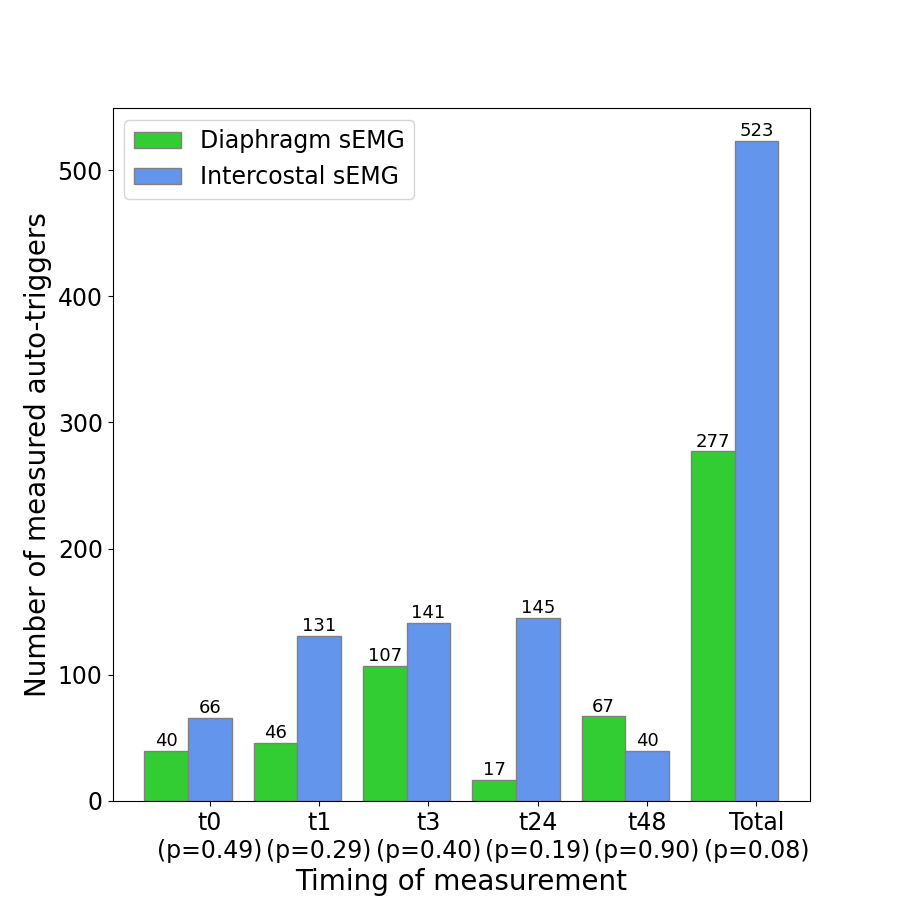

In [41]:
# Create a bar plot showing the results of the detected auto-trigger

# Save the bar plot
output_dir = r'directory' # add own directory
output_path = os.path.join(output_dir, 'auto_trigger_barplot.png')

# Settings for bar plot
barWidth = 0.4
fig = plt.subplots(figsize =(9,9))

dia = df_auto_trigger_all['diaphragm sEMG']
int = df_auto_trigger_all['intercostal sEMG']

br1 = np.arange(len(dia)) 
br2 = [x + barWidth for x in br1]

plt.bar(br1, dia, color ='limegreen', width = barWidth, 
        edgecolor ='grey', label ='Diaphragm sEMG') 
plt.bar(br2, int, color ='cornflowerblue', width = barWidth, 
        edgecolor ='grey', label ='Intercostal sEMG')

for i, v in enumerate(dia):
    plt.text(br1[i], v + 0.5, str(v), ha='center', va='bottom', fontsize=13, color='black')

for i, v in enumerate(int):
    plt.text(br2[i], v + 0.5, str(v), ha='center', va='bottom', fontsize=13, color='black')

plt.xlabel('Timing of measurement', fontweight ='normal', fontsize = 20) 
plt.ylabel('Number of measured auto-triggers', fontweight ='normal', fontsize = 20) 
plt.xticks([r + barWidth for r in range(len(dia))], 
        ['t0\n(p=0.49)', 't1\n(p=0.29)', 't3\n(p=0.40)', 't24\n(p=0.19)', 't48\n(p=0.90)', 'Total\n(p=0.08)'], fontsize=17)
plt.yticks(fontsize=17)

plt.legend(fontsize=17)

plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')

plt.show() 

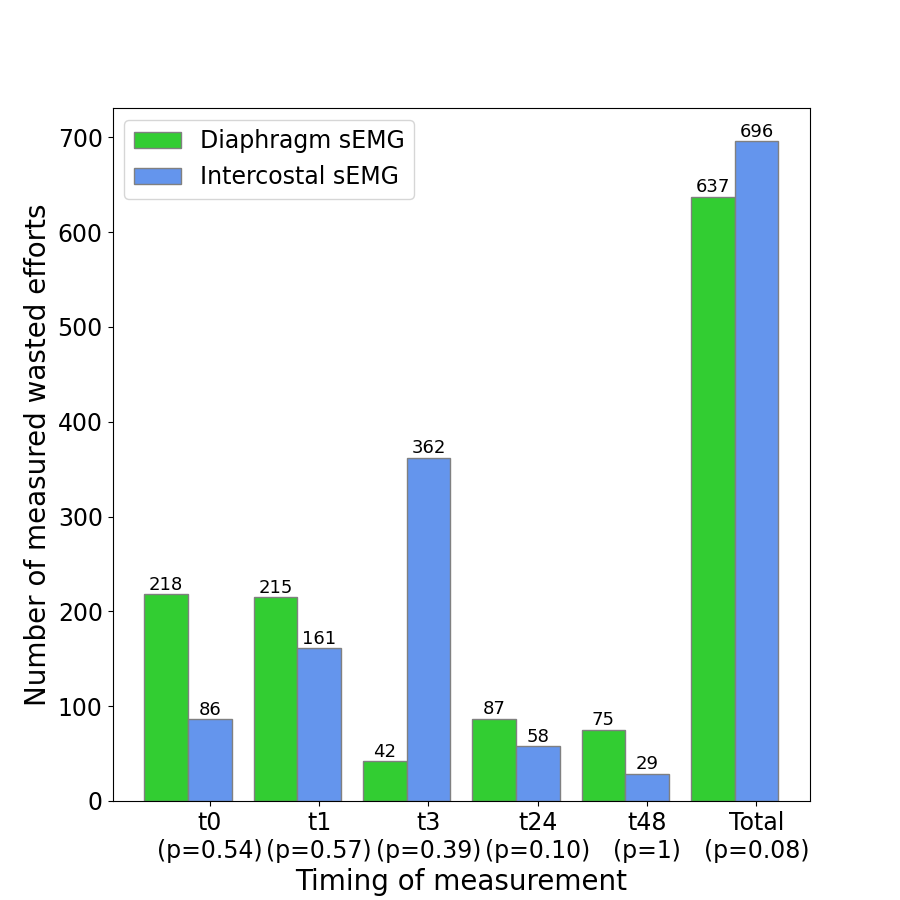

In [61]:
# Create a bar plot showing the results of the detected wasted effort

# Save the bar plot
output_dir = r'directory' #add own directory
output_path = os.path.join(output_dir, 'wasted_effort_barplot.png')

# Settings for bar plot
barWidth = 0.4
fig = plt.subplots(figsize =(9,9))

dia = df_wasted_effort_time_all['diaphragm sEMG']
int = df_wasted_effort_time_all['intercostal sEMG']

br1 = np.arange(len(dia)) 
br2 = [x + barWidth for x in br1]

plt.bar(br1, dia, color ='limegreen', width = barWidth, 
        edgecolor ='grey', label ='Diaphragm sEMG') 
plt.bar(br2, int, color ='cornflowerblue', width = barWidth, 
        edgecolor ='grey', label ='Intercostal sEMG')

for i, v in enumerate(dia):
    plt.text(br1[i], v + 0.5, str(v), ha='center', va='bottom', fontsize=13, color='black')

for i, v in enumerate(int):
    plt.text(br2[i], v + 0.5, str(v), ha='center', va='bottom', fontsize=13, color='black')

plt.xlabel('Timing of measurement', fontweight ='normal', fontsize = 20) 
plt.ylabel('Number of measured wasted efforts', fontweight ='normal', fontsize = 20) 
plt.xticks([r + barWidth for r in range(len(dia))], 
        ['t0\n(p=0.54)', 't1\n(p=0.57)', 't3\n(p=0.39)', 't24\n(p=0.10)', 't48\n(p=1)', 'Total\n(p=0.08)'], fontsize=17)
plt.yticks(fontsize=17)

plt.legend(fontsize=17)

plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')

plt.show() 

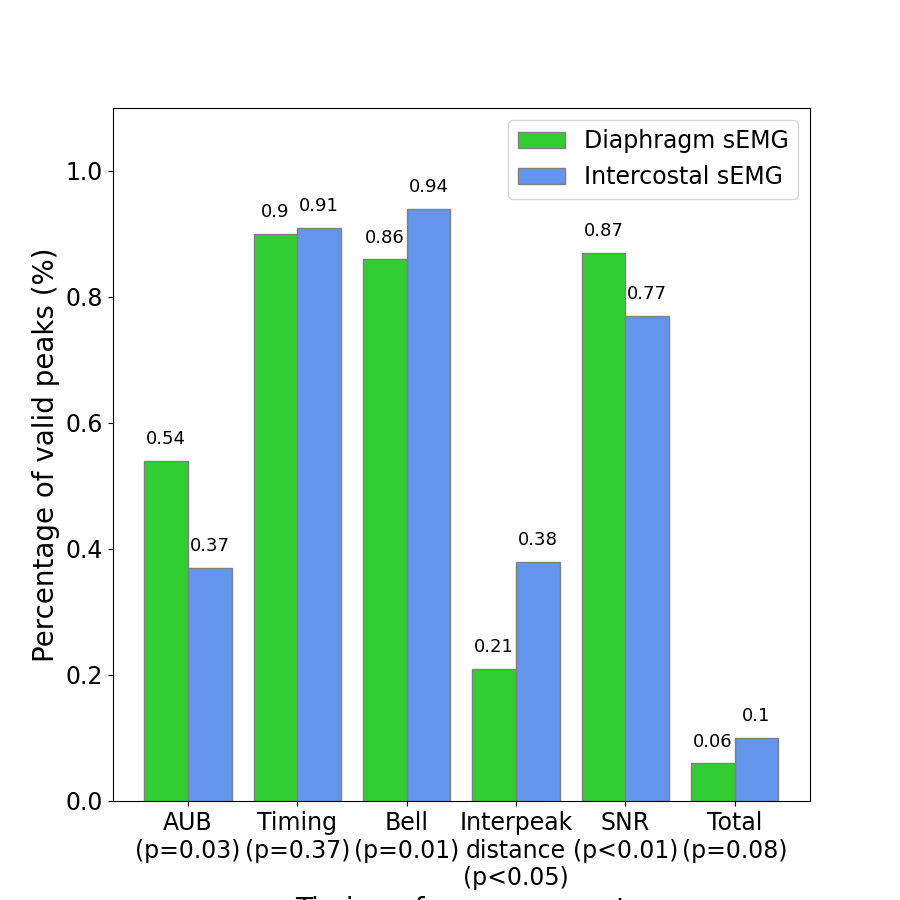

In [62]:
# Create a bar plot showing the results of the quality assessments

# Save directory and path
output_dir = r'C:\Users\cmelb\Downloads\Figuren_stage1' # Update if needed
output_path = os.path.join(output_dir, 'quality_barplot.png')

# Settings for bar plot
barWidth = 0.4
fig, ax = plt.subplots(figsize=(9, 9))

# Data extraction and rounding
dia = df_outcomes_quality_int_all['percentage_dia']
dia = [round(x, 2) for x in dia]
int = df_outcomes_quality_int_all['percentage_int']
int = [round(x, 2) for x in int]

# Bar positions
br1 = np.arange(len(dia))
br2 = [x + barWidth for x in br1]

# Plot bars
ax.bar(br1, dia, color='limegreen', width=barWidth, edgecolor='grey', label='Diaphragm sEMG')
ax.bar(br2, int, color='cornflowerblue', width=barWidth, edgecolor='grey', label='Intercostal sEMG')

# Add labels above the bars
for i, v in enumerate(dia):
    ax.text(br1[i], v + 0.02, str(v), ha='center', va='bottom', fontsize=13)  # Adjust position for dia values

for i, v in enumerate(int):
    ax.text(br2[i], v + 0.02, str(v), ha='center', va='bottom', fontsize=13)  # Adjust position for int values

# Labels and title
ax.set_xlabel('Timing of measurement', fontweight='normal', fontsize=20)
ax.set_ylabel('Percentage of valid peaks (%)', fontweight='normal', fontsize=20)
ax.set_xticks([r + barWidth/2 for r in range(len(dia))])
ax.set_xticklabels(['AUB\n(p=0.03)', 'Timing\n(p=0.37)', 'Bell\n(p=0.01)', 
                    'Interpeak\ndistance\n(p<0.05)', 'SNR\n(p<0.01)', 'Total\n(p=0.08)'], fontsize=17)
ax.tick_params(axis='y', labelsize=17)

# Legend and limits
ax.legend(fontsize=17)
ax.set_ylim(0, 1.1)

# Save plot
plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')
plt.show()

In [76]:
df_specific_outcomes_auto_trigger_time = df_specific_outcomes_auto_trigger.groupby(['Time']).sum().reset_index()
df_specific_outcomes_auto_trigger_time.loc['Total'] = df_specific_outcomes_auto_trigger_time.sum()
df_specific_outcomes_wasted_effort_time = df_specific_outcomes_wasted_effort.groupby(['Time']).sum().reset_index()
df_specific_outcomes_wasted_effort_time.loc['Total'] = df_specific_outcomes_wasted_effort_time.sum()
df_specific_outcomes_wasted_effort_time


,Time,Patient,Only diaphragm,Only intercostal,Both
0,t0,136,213,81,5
1,t1,136,211,157,4
2,t24,96,33,353,9
3,t3,101,83,54,4
4,t48,57,65,19,10
Total,t0t1t24t3t48,526,605,664,32


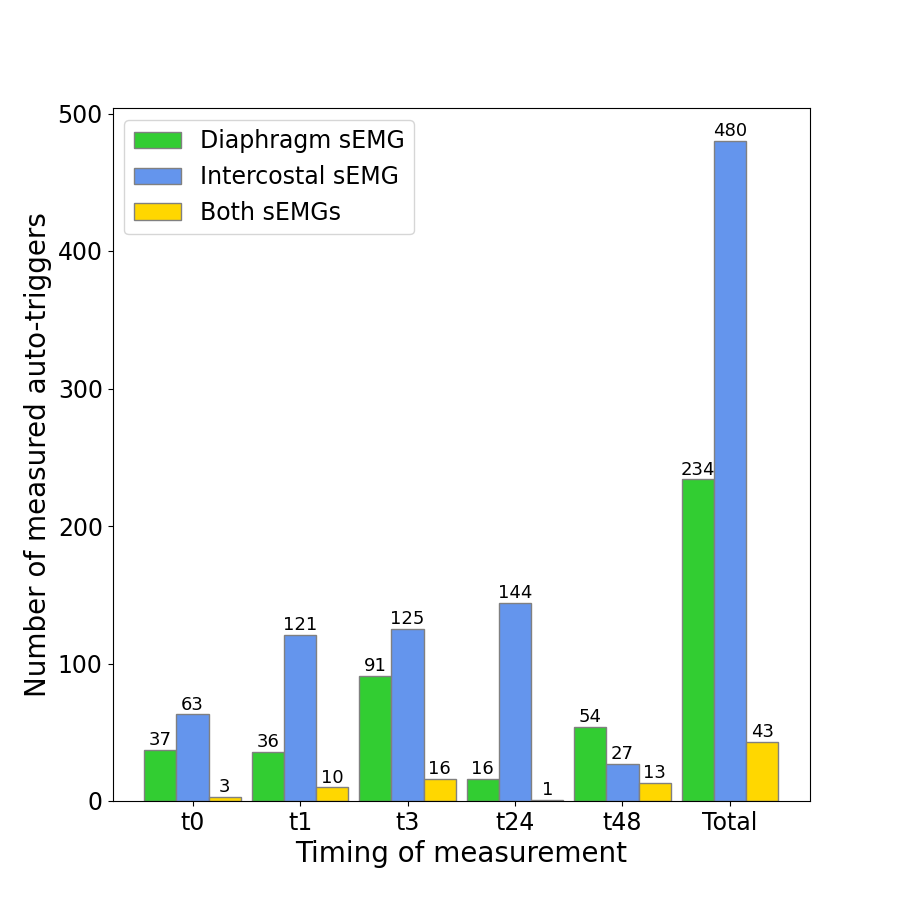

In [205]:
# Create a bar plot showing the results of the auto-trigger specific

# Save the bar plot
output_dir = r'directory' #add own directory
output_path = os.path.join(output_dir, 'auto_trigger_specific_barplot.png')

# Settings for bar plot
barWidth = 0.3
fig = plt.subplots(figsize =(9,9))

dia = df_specific_outcomes_auto_trigger_time['Only diaphragm']
int = df_specific_outcomes_auto_trigger_time['Only intercostal']
both = df_specific_outcomes_auto_trigger_time['Both']

br1 = np.arange(len(dia)) 
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, dia, color ='limegreen', width = barWidth, 
        edgecolor ='grey', label ='Diaphragm sEMG') 
plt.bar(br2, int, color ='cornflowerblue', width = barWidth, 
        edgecolor ='grey', label ='Intercostal sEMG')
plt.bar(br3, both, color ='gold', width = barWidth, 
        edgecolor ='grey', label ='Both sEMGs')


for i, v in enumerate(dia):
    plt.text(br1[i], v + 0.5, str(v), ha='center', va='bottom', fontsize=13, color='black')

for i, v in enumerate(int):
    plt.text(br2[i], v + 0.5, str(v), ha='center', va='bottom', fontsize=13, color='black')

for i, v in enumerate(both):
    plt.text(br3[i], v + 0.5, str(v), ha='center', va='bottom', fontsize=13, color='black')

plt.xlabel('Timing of measurement', fontweight ='normal', fontsize = 20) 
plt.ylabel('Number of measured auto-triggers', fontweight ='normal', fontsize = 20) 
plt.xticks([r + barWidth for r in range(len(dia))], 
        ['t0', 't1', 't3', 't24', 't48', 'Total'], fontsize=17)
plt.yticks(fontsize=17)

plt.legend(fontsize=17)

plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')

plt.show() 

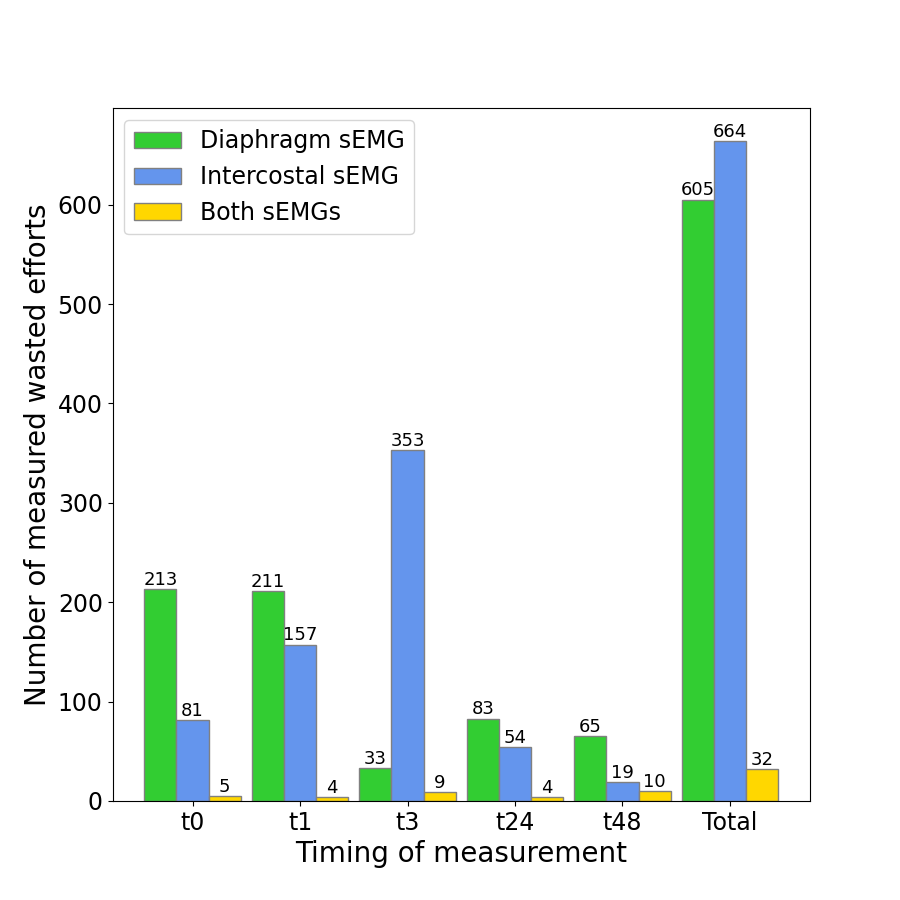

In [206]:
# Create a bar plot showing the results of the wasted effort specific

# Save the bar plot
output_dir = r'directory' #add own directory
output_path = os.path.join(output_dir, 'wasted_effort_specific_barplot.png')

# Settings for bar plot
barWidth = 0.3
fig = plt.subplots(figsize =(9,9))

dia = df_specific_outcomes_wasted_effort_time['Only diaphragm']
int = df_specific_outcomes_wasted_effort_time['Only intercostal']
both = df_specific_outcomes_wasted_effort_time['Both']

br1 = np.arange(len(dia)) 
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, dia, color ='limegreen', width = barWidth, 
        edgecolor ='grey', label ='Diaphragm sEMG') 
plt.bar(br2, int, color ='cornflowerblue', width = barWidth, 
        edgecolor ='grey', label ='Intercostal sEMG')
plt.bar(br3, both, color ='gold', width = barWidth, 
        edgecolor ='grey', label ='Both sEMGs')


for i, v in enumerate(dia):
    plt.text(br1[i], v + 0.5, str(v), ha='center', va='bottom', fontsize=13, color='black')

for i, v in enumerate(int):
    plt.text(br2[i], v + 0.5, str(v), ha='center', va='bottom', fontsize=13, color='black')

for i, v in enumerate(both):
    plt.text(br3[i], v + 0.5, str(v), ha='center', va='bottom', fontsize=13, color='black')

plt.xlabel('Timing of measurement', fontweight ='normal', fontsize = 20) 
plt.ylabel('Number of measured wasted efforts', fontweight ='normal', fontsize = 20) 
plt.xticks([r + barWidth for r in range(len(dia))], 
        ['t0', 't1', 't3', 't24', 't48', 'Total'], fontsize=17)
plt.yticks(fontsize=17)

plt.legend(fontsize=17)

plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')

plt.show() 